In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## follow the instructions on the website
def unpickle(file):
    ## used to read binary files since our data files are in binary format
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
## loading data from binary data files
batch_1_dictionary = unpickle('cifar-10-batches-py/data_batch_1')
batch_2_dictionary = unpickle('cifar-10-batches-py/data_batch_2')

In [3]:
batch_1_dictionary.keys()


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [4]:
## get training, validation and testing sets
X_train_all = np.array(batch_1_dictionary[b'data']).reshape(10000, 3, 32, 32)
y_train_all = np.array(batch_1_dictionary[b'labels'])
validation_count = 1000
train_count = X_train_all.shape[0] - 1000
X_train = X_train_all[:train_count]
y_train = y_train_all[:train_count]
X_val = X_train_all[train_count:]
y_val = y_train_all[train_count:]
X_test = np.array(batch_2_dictionary[b'data']).reshape(10000, 3, 32, 32)
y_test = np.array(batch_2_dictionary[b'labels'])


In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((9000, 3, 32, 32),
 (9000,),
 (1000, 3, 32, 32),
 (1000,),
 (10000, 3, 32, 32),
 (10000,))

In [6]:
# for RGB data we can simply divide by 255
X_train_normalized = X_train / 255
X_val_normalized = X_val / 255
X_test_normalized = X_test / 255


In [7]:
# here load all classes from new source
metadic = unpickle('cifar-10-batches-py/batches.meta')
CLASSES=list(map(lambda x: x.decode(), metadic[b'label_names']))
print(CLASSES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
## class label related
# old version of CLASSES not in use
# CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def index_to_class_name(y):
    return CLASSES[y]
def class_name_to_index(class_name):
    return CLASSES.index(class_name)

In [9]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

"""
Plotting utilities, if you want to know how these work exactly, check the reference
Or the documentations
reference: 
https://matplotlib.org/users/image_tutorial.html
https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
"""

def show_single_image(data):
    # show a single image
    ## note that using matplotlib plotting function, we will have to reshape the data as (1,32,32,3)
    img = data.reshape(3, 32, 32).transpose(1, 2, 0)
    imgplot = plt.imshow(img)
def show_multiple_images(data, data_y, n_show=12, columns=4):
    ## given an array of data, show all of them as images
    fig = plt.figure(figsize=(8, 8))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n / columns)
    for i in range(n):
        img = data[i].reshape(3, 32, 32).transpose(1, 2, 0)
        ax = fig.add_subplot(rows, columns, i + 1)  ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i]) + ": " + class_name)
        plt.imshow(img)
    plt.show()


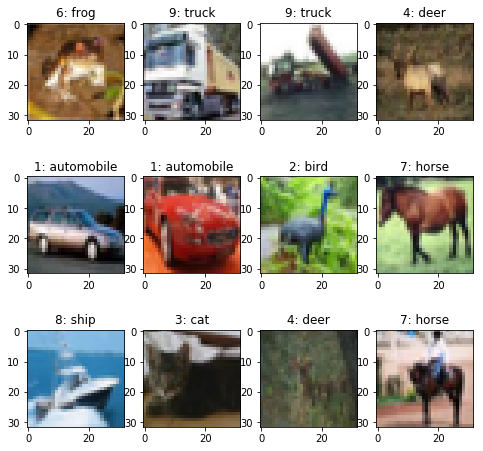

In [10]:
show_multiple_images(X_train, y_train)


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim


class MLP(nn.Module):
    ## a very simple MLP model
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        hidden_dim = 32
        self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(True))
        self.fc2 = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.ReLU(True))
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, output_dim)
        # self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.Sigmoid())
        # self.fc2 = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Sigmoid())
    def forward(self, x):
        hval = self.fc1(x)
        oval = self.fc2(hval)
        return oval


In [27]:
# utility for getting prediction accuracy
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _, pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct, correct / n


In [45]:
# init network
mlp = MLP(3072, 10)
print('model structure: ', mlp)

# init optimizer
learning_rate = 0.15
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

# set loss function
criterion = nn.CrossEntropyLoss()

# prepare for mini-batch stochastic gradient descent
n_iteration = 100 * 3
batch_size = 256
n_train_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_train_data / batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = torch.Tensor(X_train_normalized).flatten(start_dim=1, end_dim=3)
X_val_tensor = torch.Tensor(X_val_normalized).flatten(start_dim=1, end_dim=3)
X_test_tensor = torch.Tensor(X_test_normalized).flatten(start_dim=1, end_dim=3)

# convert training label to tensor and to type long
y_train_tensor = torch.Tensor(y_train).long()
y_val_tensor = torch.Tensor(y_val).long()
y_test_tensor = torch.Tensor(y_test).long()

print(X_train_tensor.size())
print(y_train_tensor.type())


model structure:  MLP(
  (fc1): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU(inplace)
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): ReLU(inplace)
  )
)


torch.Size([9000, 3072])
torch.LongTensor


In [46]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)

for i in range(n_iteration):
    # first get a minibatch of data
    temp_train_loss_list = np.zeros(n_batch)
    temp_train_accu_list = np.zeros(n_batch)
    temp_val_loss_list = np.zeros(n_batch)
    temp_val_accu_list = np.zeros(n_batch)
    for j in range(n_batch):
        batch_start_index = j * batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index + batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index + batch_size]
        y_train_result = mlp(X_batch)
        y_val_result = mlp(X_val_tensor)
        _, temp_train_accu = get_correct_and_accuracy(y_train_result, y_batch)
        _, temp_val_accu = get_correct_and_accuracy(y_val_result, y_val_tensor)
        temp_train_loss = criterion(y_train_result, y_batch)
        temp_val_loss = criterion(y_val_result, y_val_tensor)

        temp_train_loss_list[j] = temp_train_loss
        temp_val_loss_list[j] = temp_val_loss
        temp_train_accu_list[j] = temp_train_accu
        temp_val_accu_list[j] = temp_val_accu

        # train step here
        optimizer.zero_grad()
        temp_train_loss.backward()
        optimizer.step()

    ave_train_loss = temp_train_loss_list.mean()
    ave_val_loss = temp_val_loss_list.mean()
    train_accu = temp_train_accu_list.mean()
    val_accu = temp_val_accu_list.mean()
    if i % 10 == 0:
        print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f"
              % (i, ave_train_loss, train_accu, ave_val_loss, val_accu))

    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = ave_val_loss
    val_accu_list[i] = val_accu


Iter 0 ,Train loss: 2.294, Train acc: 0.125, Val loss: 2.298, Val acc: 0.115


Iter 10 ,Train loss: 2.114, Train acc: 0.257, Val loss: 2.141, Val acc: 0.240


Iter 20 ,Train loss: 2.028, Train acc: 0.304, Val loss: 2.058, Val acc: 0.289


Iter 30 ,Train loss: 1.982, Train acc: 0.320, Val loss: 2.022, Val acc: 0.311


Iter 40 ,Train loss: 1.947, Train acc: 0.334, Val loss: 2.006, Val acc: 0.314


Iter 50 ,Train loss: 1.915, Train acc: 0.347, Val loss: 1.998, Val acc: 0.312


Iter 60 ,Train loss: 1.854, Train acc: 0.366, Val loss: 1.954, Val acc: 0.327


Iter 70 ,Train loss: 1.776, Train acc: 0.397, Val loss: 1.904, Val acc: 0.343


Iter 80 ,Train loss: 1.710, Train acc: 0.421, Val loss: 1.863, Val acc: 0.361


Iter 90 ,Train loss: 1.653, Train acc: 0.438, Val loss: 1.848, Val acc: 0.366


Iter 100 ,Train loss: 1.671, Train acc: 0.436, Val loss: 1.872, Val acc: 0.359


Iter 110 ,Train loss: 1.661, Train acc: 0.436, Val loss: 1.886, Val acc: 0.356


Iter 120 ,Train loss: 1.601, Train acc: 0.460, Val loss: 1.870, Val acc: 0.366


Iter 130 ,Train loss: 1.586, Train acc: 0.464, Val loss: 1.893, Val acc: 0.363


Iter 140 ,Train loss: 1.551, Train acc: 0.484, Val loss: 1.877, Val acc: 0.368


Iter 150 ,Train loss: 1.573, Train acc: 0.469, Val loss: 1.907, Val acc: 0.362


Iter 160 ,Train loss: 1.532, Train acc: 0.488, Val loss: 1.900, Val acc: 0.368


Iter 170 ,Train loss: 1.558, Train acc: 0.477, Val loss: 1.938, Val acc: 0.361


Iter 180 ,Train loss: 1.509, Train acc: 0.504, Val loss: 1.921, Val acc: 0.369


Iter 190 ,Train loss: 1.486, Train acc: 0.507, Val loss: 1.931, Val acc: 0.371


Iter 200 ,Train loss: 1.509, Train acc: 0.497, Val loss: 1.955, Val acc: 0.363


Iter 210 ,Train loss: 1.483, Train acc: 0.509, Val loss: 1.949, Val acc: 0.370


Iter 220 ,Train loss: 1.473, Train acc: 0.517, Val loss: 1.966, Val acc: 0.368


Iter 230 ,Train loss: 1.427, Train acc: 0.529, Val loss: 1.938, Val acc: 0.378


Iter 240 ,Train loss: 1.403, Train acc: 0.533, Val loss: 1.948, Val acc: 0.375


Iter 250 ,Train loss: 1.389, Train acc: 0.538, Val loss: 1.942, Val acc: 0.375


Iter 260 ,Train loss: 1.370, Train acc: 0.540, Val loss: 1.954, Val acc: 0.378


Iter 270 ,Train loss: 1.332, Train acc: 0.555, Val loss: 1.945, Val acc: 0.383


Iter 280 ,Train loss: 1.372, Train acc: 0.541, Val loss: 1.980, Val acc: 0.376


Iter 290 ,Train loss: 1.317, Train acc: 0.560, Val loss: 1.963, Val acc: 0.380


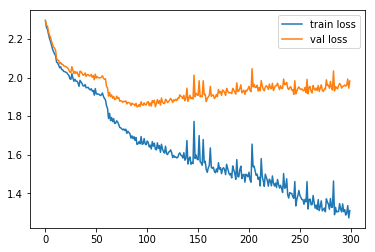

In [47]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

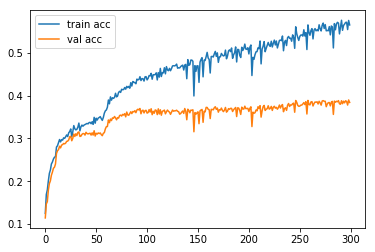

In [48]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [49]:
## test performance on the test set and report final performance
_, test_accu = get_correct_and_accuracy(mlp(X_test_tensor), y_test_tensor)
print("Test accuracy: ", test_accu)


Test accuracy:  0.355


In [24]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )  # output of conv1 is 16*16 with 16 layers
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )  # output of conv2 is 8*8 with 32 layers
        self.output = nn.Linear(8*8*32, 10)

    def forward(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        flatten = c2.view(c2.size(0), -1) #flat (batch_size, 32*7*7)
        oval = self.output(flatten)
        return oval


In [25]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)

# init optimizer
learning_rate = 0.15
optimizer = optim.SGD(conv_net.parameters(), lr=learning_rate)

# set loss function
criterion = nn.CrossEntropyLoss()

# prepare for mini-batch stochastic gradient descent
n_iteration = 40
batch_size = 256
n_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_data / batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = torch.Tensor(X_train_normalized)
X_val_tensor = torch.Tensor(X_val_normalized)
X_test_tensor = torch.Tensor(X_test_normalized)

# convert training label to tensor and to type long
y_train_tensor = torch.Tensor(y_train).long()
y_val_tensor = torch.Tensor(y_val).long()
y_test_tensor = torch.Tensor(y_test).long()

print(X_train_tensor.size())
print(y_train_tensor.type())


model structure:  ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Linear(in_features=2048, out_features=10, bias=True)
)


torch.Size([9000, 3, 32, 32])
torch.LongTensor


In [28]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)

for i in range(n_iteration):
    # first get a minibatch of data
    temp_train_loss_list = np.zeros(n_batch)
    temp_train_accu_list = np.zeros(n_batch)
    temp_val_loss_list = np.zeros(n_batch)
    temp_val_accu_list = np.zeros(n_batch)
    for j in range(n_batch):
        batch_start_index = j * batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index + batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index + batch_size]
        y_train_result = conv_net(X_batch)
        y_val_result = conv_net(X_val_tensor)
        _, temp_train_accu = get_correct_and_accuracy(y_train_result, y_batch)
        _, temp_val_accu = get_correct_and_accuracy(y_val_result, y_val_tensor)
        temp_train_loss = criterion(y_train_result, y_batch)
        temp_val_loss = criterion(y_val_result, y_val_tensor)

        temp_train_loss_list[j] = temp_train_loss
        temp_val_loss_list[j] = temp_val_loss
        temp_train_accu_list[j] = temp_train_accu
        temp_val_accu_list[j] = temp_val_accu

        # train step here
        optimizer.zero_grad()
        temp_train_loss.backward()
        optimizer.step()

    ave_train_loss = temp_train_loss_list.mean()
    ave_val_loss = temp_val_loss_list.mean()
    train_accu = temp_train_accu_list.mean()
    val_accu = temp_val_accu_list.mean()
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f"
          % (i, ave_train_loss, train_accu, ave_val_loss, val_accu))

    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = ave_val_loss
    val_accu_list[i] = val_accu


Iter 0 ,Train loss: 2.278, Train acc: 0.147, Val loss: 2.278, Val acc: 0.150


Iter 1 ,Train loss: 2.214, Train acc: 0.214, Val loss: 2.225, Val acc: 0.208


Iter 2 ,Train loss: 2.139, Train acc: 0.245, Val loss: 2.146, Val acc: 0.234


Iter 3 ,Train loss: 1.999, Train acc: 0.286, Val loss: 2.011, Val acc: 0.278


Iter 4 ,Train loss: 1.918, Train acc: 0.319, Val loss: 1.931, Val acc: 0.310


Iter 5 ,Train loss: 1.797, Train acc: 0.365, Val loss: 1.815, Val acc: 0.352


Iter 6 ,Train loss: 1.735, Train acc: 0.389, Val loss: 1.754, Val acc: 0.371


Iter 7 ,Train loss: 1.676, Train acc: 0.411, Val loss: 1.694, Val acc: 0.398


Iter 8 ,Train loss: 1.643, Train acc: 0.428, Val loss: 1.666, Val acc: 0.411


Iter 9 ,Train loss: 1.541, Train acc: 0.461, Val loss: 1.566, Val acc: 0.439


Iter 10 ,Train loss: 1.494, Train acc: 0.474, Val loss: 1.527, Val acc: 0.450


Iter 11 ,Train loss: 1.489, Train acc: 0.483, Val loss: 1.531, Val acc: 0.449


Iter 12 ,Train loss: 1.423, Train acc: 0.504, Val loss: 1.475, Val acc: 0.468


Iter 13 ,Train loss: 1.388, Train acc: 0.519, Val loss: 1.452, Val acc: 0.474


Iter 14 ,Train loss: 1.360, Train acc: 0.526, Val loss: 1.438, Val acc: 0.476


Iter 15 ,Train loss: 1.322, Train acc: 0.539, Val loss: 1.412, Val acc: 0.484


Iter 16 ,Train loss: 1.295, Train acc: 0.547, Val loss: 1.404, Val acc: 0.487


Iter 17 ,Train loss: 1.266, Train acc: 0.558, Val loss: 1.385, Val acc: 0.495


Iter 18 ,Train loss: 1.250, Train acc: 0.568, Val loss: 1.378, Val acc: 0.501


Iter 19 ,Train loss: 1.219, Train acc: 0.576, Val loss: 1.373, Val acc: 0.505


KeyboardInterrupt: 

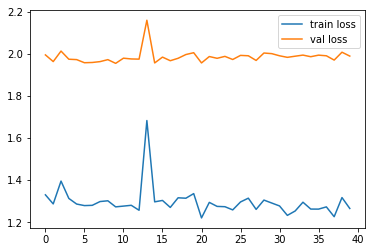

In [54]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

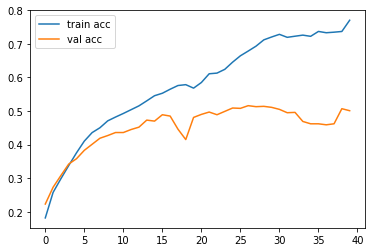

In [25]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

In [26]:
## test performance on the test set and report final performance
_, test_accu = get_correct_and_accuracy(mlp(X_test_tensor), y_test_tensor)
print("Test accuracy: ", test_accu)


Test accuracy:  0.5085


## Other things you can do to improve model performance: 
1. Add in regularization, you can use l2, Dropout
2. Use a better data normalization method
3. Train on more data
4. Do data augmentation to get more data
5. Use a more powerful network structure
6. Do transfer learning